In [3]:
from myAE import Manager

import torch
from torch import nn
import torch.nn.functional as F


In [47]:
class My_Encoder_0(nn.Module):
    def __init__(self, dim_encoder_output, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.fln = nn.Flatten()
        self.l0 = nn.Linear(784, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x):
        x = self.fln(x)
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Encoder_1(nn.Module):
    def __init__(self, dim_encoder_output, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.fln = nn.Flatten()
        self.lm0 = nn.Linear(784, 318)
        self.lm1 = nn.Linear(318, 256)
        self.ls0 = nn.Linear(784, 318)
        self.ls1 = nn.Linear(318, 256)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x):
        x = self.fln(x)
        m = self.activation(self.lm0(x))
        m = self.activation(self.lm1(m))

        s = self.activation(self.ls0(x))
        s = self.activation(self.ls1(s))

        z = self.l2(torch.cat([m, s], dim=1))
        return z

class My_Encoder_1_0(nn.Module):
    def __init__(self, dim_encoder_output, dim_m, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.fln = nn.Flatten()
        self.lm0 = nn.Linear(784, dim_m)
        self.lm1 = nn.Linear(dim_m, 256)
        self.ls0 = nn.Linear(784, 512 - dim_m)
        self.ls1 = nn.Linear(512 - dim_m, 256)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x):
        x = self.fln(x)
        m = self.activation(self.lm0(x))
        m = self.activation(self.lm1(m))

        s = self.activation(self.ls0(x))
        s = self.activation(self.ls1(s))

        z = self.l2(torch.cat([m, s], dim=1))
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim_decoder_input, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, 784)
        self.unfln = nn.Unflatten(1, [1, 28, 28])

    def forward(self, z):
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        x_hat = self.unfln(x_hat)
        return x_hat

    def step_1(self, z):
        h = self.activation(self.l0(z))
        h = self.activation(self.l1(h))
        return h

    def step_2(self, h):
        x_hat = torch.sigmoid(self.l2(h))
        x_hat = self.unfln(x_hat)
        return x_hat


In [21]:
tmp  = torch.cat([torch.rand(128, 256), torch.rand(128, 256)], dim=1)
tmp.shape

torch.Size([128, 512])

In [48]:
model = My_Encoder_0(4)
print(sum(p.numel() for p in model.parameters()))
model = My_Encoder_1_0(4, 400)
print(sum(p.numel() for p in model.parameters()))

666628
535556


In [10]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder_0(4), My_Decoder(2))

hist = manager.train(calc_loss, epochs=50)

Now, it is working on cuda:0.


100%|██████████| 50/50 [04:42<00:00,  5.65s/it]


In [23]:
manager_1 = Manager()
manager_1.prepare_data()
manager_1.set_model(My_Encoder_1(4), My_Decoder(2))

hist_1 = manager_1.train(calc_loss, epochs=50)

Now, it is working on cuda:0.


100%|██████████| 50/50 [04:57<00:00,  5.96s/it]


- manager_1_1은 파라메터 맞춘것 , 첫 층이 318
- 1 2 는 평균에 400

In [37]:
manager_1_1 = Manager()
manager_1_1.prepare_data()
manager_1_1.set_model(My_Encoder_1(4), My_Decoder(2))

hist_1_1 = manager_1_1.train(calc_loss, epochs=50)

Now, it is working on cuda:0.


100%|██████████| 50/50 [05:49<00:00,  7.00s/it]


In [50]:
manager_1_2 = Manager()
manager_1_2.prepare_data()
manager_1_2.set_model(My_Encoder_1_0(4, 400), My_Decoder(2))

hist_1_2 = manager_1_2.train(calc_loss, epochs=50)

Now, it is working on cuda:0.


100%|██████████| 50/50 [06:18<00:00,  7.57s/it]


In [54]:
manager_1_3 = Manager()
manager_1_3.prepare_data()
manager_1_3.set_model(My_Encoder_1_0(4, 512 - 400), My_Decoder(2))

hist_1_3 = manager_1_3.train(calc_loss, epochs=50)

Now, it is working on cuda:0.


100%|██████████| 50/50 [06:33<00:00,  7.88s/it]


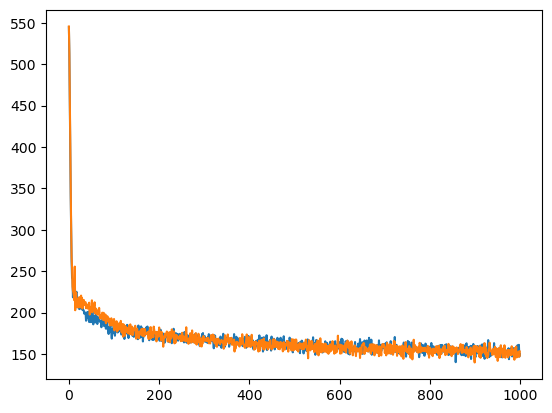

In [57]:
import matplotlib.pyplot as plt

plt.plot(hist[:1000])
plt.plot(hist_1_3[:1000])
plt.show()